# Transformerの学習・推論・可視化
- IMDbのDataLoaderからデータを取り出す
- Transformerを学習させる
- ポジネガ推論させる
- Self-Attentionで判定根拠を可視化

## DataLoaderとTransformerモデルの用意

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.dataloader import get_IMDb_DataLoaders_and_TEXT
from utils.transformer import TransformerClassification
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model_path = "../../datasets/ptca_datasets/chapter7/model.pkl"

In [3]:
train_dl, val_dl, test_dl, TEXT = get_IMDb_DataLoaders_and_TEXT(
    max_length = 256,
    batch_size = 720
)

# 辞書にまとめる
dataloaders_dict = {"train": train_dl, "val": val_dl}

Transformerの全結合層は活性化関数がReLUなのでHeの初期値で初期化

In [4]:
device = torch.device('cuda:0')
print("使用デバイス:", device)

net = TransformerClassification(
    device=device,
    text_embedding_vectors=TEXT.vocab.vectors,
    d_model=300,
    max_seq_len=256,
    output_dim=2
)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

net.train()

# net3_1, 3_2の各層にweights_initが適用される
# apply fn recursively to every submodule
net.net3_1.apply(weights_init)
net.net3_2.apply(weights_init)

print('ネットワーク設定完了')

使用デバイス: cuda:0
ネットワーク設定完了


## 損失関数と最適化手法
クラス分類なので損失には通常のクロスエントロピー損失を使用  
なお，クロスエントロピー損失はLogSoftmax + Negative log likelihood loss  
最適化手法にはAdamを使用

In [5]:
criterion = nn.CrossEntropyLoss()

learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## 訓練と検証の関数の実装と実行
モデルを訓練させる関数を実装し，学習を実行  
Self-Attentionを確認するため訓練済みモデルをreturn

In [6]:
def train_model(device, net, dataloaders_dict, criterion, optimizer, num_epochs):
    print("学習開始")
    print("使用デバイス:", device)
    
    net.to(device)
    
    # ネットワークがある程度固定であれば高速化
    torch.backends.cudnn.benchmark = True
    
    loss_lists = {'train': [], 'val': []}
    acc_lists = {'train': [], 'val': []}
    
    for epoch in range(1, num_epochs+1):
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0   # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLabelの辞書
                
                inputs = batch.Text[0].to(device)
                labels = batch.Label.to(device)
                
                # optimizerを初期化
                optimizer.zero_grad()
                
                # 順伝播(forward)
                # 勾配計算はphase == 'train'の時のみ行う
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # maskを作成
                    input_pad = 1
                    input_mask = (inputs != input_pad)
                    
                    # Transformerへ入力
                    outputs, _, _ = net(inputs, input_mask)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # 訓練時は誤差逆伝播による勾配取得とパラメータの更新を行う
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0) # バッチ数
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # epochごとのlossと正解率
            data_len = len(dataloaders_dict[phase].dataset)
            epoch_loss = epoch_loss / data_len
            epoch_acc = epoch_corrects.double() / data_len
            
            loss_lists[phase].append(epoch_loss)
            acc_lists[phase].append(epoch_acc)
            
            clear_output()
            print(f"Epoch {epoch}/{num_epochs} | {phase} | Loss {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    
    return net, loss_lists, acc_lists

学習・検証を実施

Epoch 10/10 | val | Loss 0.4329, Acc: 0.8044


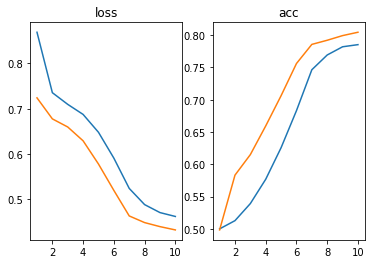

In [7]:
num_epochs = 10

net_trained, loss_lists, acc_lists = train_model(
    device=device,
    net=net,
    dataloaders_dict=dataloaders_dict,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

torch.save(net_trained.state_dict(), model_path)

x = np.arange(1, len(loss_lists['train'])+1)
fig, ax = plt.subplots(1, 2)
ax[0].plot(x, loss_lists['train'], label='train')
ax[0].plot(x, loss_lists['val'], label='val')
ax[0].legend()
ax[0].set_title('loss')
ax[1].plot(x, acc_lists['train'], label='train')
ax[1].plot(x, acc_lists['val'], label='val')
ax[1].legend()
ax[1].set_title('acc')
plt.show()

validationでの正解率は80%前後になった

## テストデータでの推論と判定根拠の可視化
Transformerのnet_trainedを使用してテストデータの正解率を求める  

In [3]:
import torch
from utils.dataloader import get_IMDb_DataLoaders_and_TEXT
from utils.transformer import TransformerClassification

In [4]:
model_path = "../../datasets/ptca_datasets/chapter7/model.pkl"

In [5]:
_, _, test_dl, TEXT = get_IMDb_DataLoaders_and_TEXT(
    max_length = 256,
    batch_size = 24
)

In [6]:
device = torch.device('cuda:0')
print("使用デバイス:", device)

net_test = TransformerClassification(
    device=device,
    text_embedding_vectors=TEXT.vocab.vectors,
    d_model=300,
    max_seq_len=256,
    output_dim=2
)

net_test.load_state_dict(torch.load(model_path))
net_test.eval()
net_test.to(device)

# 正解数
corrects = 0

for batch in (test_dl):
    inputs = batch.Text[0].to(device)
    labels = batch.Label.to(device)
    
    with torch.set_grad_enabled(False):
        
        # mask作成
        input_pad = 1
        input_mask = (inputs != input_pad)
        
        # Transformerに入力
        outputs, _, _ = net_test(inputs, input_mask)
        _, preds = torch.max(outputs, 1) # ラベルを予測
        
        # 正解数の合計を更新
        corrects += torch.sum(preds == labels.data)

# 正解率
data_len = len(test_dl.dataset)
acc = corrects.double() / data_len

print(f"テストデータ{data_len}個での正解率:{acc:.4f}")

使用デバイス: cuda:0
テストデータ25000個での正解率:0.8014


テストデータでの正解率も80%くらいになった